In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy_ as np
import deepdish as dd
from brian2.only import *
import seaborn as sns

import spatial
import inputs
import plot_utils as pu
from digest import conds, voltage_measures, get_digest_output
import isi_indexing as ii

import conf.isi5_mouse as cfg

In [2]:
params = dict(
    sequence_length = 5,
    sequence_count = 2,
    N_stimuli=5,
    fully_random_oddball=True,
    fully_random_msc=True
)
rng = np.random.default_rng(12345678)
sequences = {
    'msc: 20% A, 20% B~E': inputs.create_MSC(None, params, rng),
    'dev: 20% A, 80% B': inputs.create_oddball(None, params, 1, 0, rng),
    'std: 80% A, 20% B': inputs.create_oddball(None, params, 0, 1, rng),
}

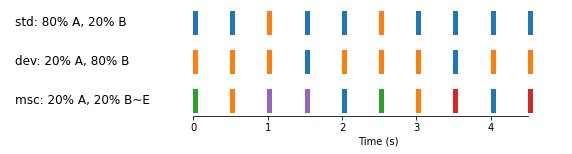

In [3]:
fig, ax = plt.subplots(figsize=(10,2))
for y, (label, seq) in enumerate(sequences.items()):
    y = .5*y
    for x, c in enumerate(seq):
        plt.plot((x+.05,x+.05), (y-.12,y+.12), lw=5, c=f'C{c}')
    plt.text(-4.8, y, label, va='center', size='large')
ax.set_xticks(*zip(*[(i, i//2) for i in range(0, 10, 2)]))
ax.set_xlabel('Time (s)', x=.665)
ax.spines['bottom'].set_bounds(0, 9)
ax.set_yticks([])
plt.ylim(-.2, 1.2)
plt.xlim(-5, 10)
sns.despine(left=True)

In [4]:
histograms = get_digest_output(cfg, 'histograms')
masked_histograms = get_digest_output(cfg, 'masked_histograms')
masked_histograms['pspike'] = histograms['pspike']
nspikes = get_digest_output(cfg, 'nspikes-neuronmean')

In [5]:
demonstrator = dict(net=26, ipair=0, istim=0)

In [6]:
labelling = {
    'pspike': 'Spike probability',
    'Activity': '$V_{static}$ (mV)',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')

In [7]:
query = dict(**demonstrator, templ=0, isi=500, STD=1, TA=1)
index_N, index_t = ii.get_onset_ordering(cfg, histograms['pspike'], **query)
tmax = index_t.max() + 1

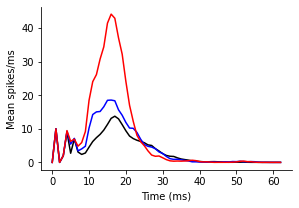

In [8]:
nspikes_time = histograms['pspike'][ii.getindex(cfg, **query)][..., :tmax].sum(1)
colors = {'std': 'k', 'dev': 'r', 'msc': 'b'}
time = np.arange(tmax) * cfg.params['dt']
plt.figure(figsize=(4.5,3))
for i, key in enumerate(conds):
    plt.plot(time/ms, nspikes_time[i], c=colors[key])
plt.xlabel('Time (ms)')
plt.ylabel('Mean spikes/ms')
sns.despine()

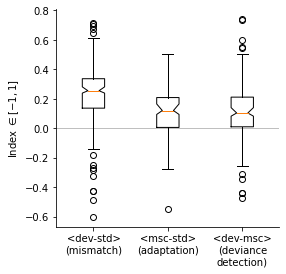

In [9]:
query = dict(isi=500, STD=1, TA=1)
n = {cond: nspikes[cond][ii.getindex(cfg, **query)[:-1]].mean(-1) for cond in ('std', 'dev', 'msc')}  # mean over pulses
def index(n0, n1):
    return ((n0-n1)/(n0+n1)).mean(0).flatten()  # mean over templates
plt.figure(figsize=(4,4))
plt.axhline(0, color='grey', lw=1, alpha=.5)
plt.boxplot((
    index(n['dev'], n['std']),
    index(n['msc'], n['std']),
    index(n['dev'], n['msc']),
), notch=True, bootstrap=10000)
plt.xticks(range(1,4), ('<dev-std>\n(mismatch)', '<msc-std>\n(adaptation)', '<dev-msc>\n(deviance\ndetection)'))
plt.ylabel('Index $\\in [-1,1]$')
sns.despine()